In [46]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
import shap

In [28]:
df_freq = fetch_openml(data_id=41214, as_frame=True, parser="pandas").data
df_freq["IDpol"] = df_freq["IDpol"].astype("int")
df_freq.set_index("IDpol", inplace=True)
df_freq.drop("ClaimNb", axis=1, inplace=True)
df_freq

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
IDpol,,,,,,,,,,
1,0.10000,D,5,0,55,50,B12,'Regular',1217,R82
3,0.77000,D,5,0,55,50,B12,'Regular',1217,R82
5,0.75000,B,6,2,52,50,B12,'Diesel',54,R22
10,0.09000,B,7,0,46,50,B12,'Diesel',76,R72
11,0.84000,B,7,0,46,50,B12,'Diesel',76,R72
...,...,...,...,...,...,...,...,...,...,...
6114326,0.00274,E,4,0,54,50,B12,'Regular',3317,R93
6114327,0.00274,E,4,0,41,95,B12,'Regular',9850,R11
6114328,0.00274,D,6,2,45,50,B12,'Diesel',1323,R82


In [29]:
df_sev = fetch_openml(data_id=41215, as_frame=True, parser="pandas").data
df_sev = df_sev.groupby("IDpol").sum()
df_sev

,ClaimAmount
IDpol,
139,303.00
190,1981.84
414,1456.55
424,10834.00
463,3986.67
...,...
6113521,1324.40
6113793,1769.88
6113817,1288.28


In [30]:
df = df_freq.join(df_sev, how="left")
df["ClaimAmount"].fillna(0, inplace=True)
for column_name in df.columns[df.dtypes.values == object]:
    df[column_name] = df[column_name].str.strip("'")
df

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,
1,0.10000,D,5,0,55,50,B12,Regular,1217,R82,0.0
3,0.77000,D,5,0,55,50,B12,Regular,1217,R82,0.0
5,0.75000,B,6,2,52,50,B12,Diesel,54,R22,0.0
10,0.09000,B,7,0,46,50,B12,Diesel,76,R72,0.0
11,0.84000,B,7,0,46,50,B12,Diesel,76,R72,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6114326,0.00274,E,4,0,54,50,B12,Regular,3317,R93,0.0
6114327,0.00274,E,4,0,41,95,B12,Regular,9850,R11,0.0
6114328,0.00274,D,6,2,45,50,B12,Diesel,1323,R82,0.0


In [38]:
y = df["ClaimAmount"]
weights = df["Exposure"]
X = df[[col for col in df.columns if col not in ["Exposure", "ClaimAmount"]]]
train_y, test_y, train_weights, test_weights, train_X, test_X = train_test_split(y, weights, X, test_size=.2, random_state=42)


In [49]:
cb_regressor = CatBoostRegressor(
    loss_function="Tweedie:variance_power=1.5",
    depth=1
)
cb_regressor.fit(
    train_X,
    train_y,
    sample_weight=train_weights,
    cat_features=["Area", "VehBrand", "VehGas", "Region"],
    eval_set=(test_X, test_y)
)

0:	learn: 190.5491746	test: 172.0365603	best: 172.0365603 (0)	total: 30.6ms	remaining: 30.6s
1:	learn: 185.1583432	test: 167.1857563	best: 167.1857563 (1)	total: 59.1ms	remaining: 29.5s
2:	learn: 179.9337480	test: 162.4873078	best: 162.4873078 (2)	total: 91.1ms	remaining: 30.3s
3:	learn: 174.8708127	test: 157.9324733	best: 157.9324733 (3)	total: 112ms	remaining: 27.8s
4:	learn: 169.9648701	test: 153.5193976	best: 153.5193976 (4)	total: 134ms	remaining: 26.6s
5:	learn: 165.2113661	test: 149.2464589	best: 149.2464589 (5)	total: 154ms	remaining: 25.6s
6:	learn: 160.6060739	test: 145.1073719	best: 145.1073719 (6)	total: 174ms	remaining: 24.7s
7:	learn: 156.1449267	test: 141.0958636	best: 141.0958636 (7)	total: 194ms	remaining: 24.1s
8:	learn: 151.8236227	test: 137.2133713	best: 137.2133713 (8)	total: 215ms	remaining: 23.7s
9:	learn: 147.6383398	test: 133.4537619	best: 133.4537619 (9)	total: 235ms	remaining: 23.2s
10:	learn: 143.5854122	test: 129.8109046	best: 129.8109046 (10)	total: 256ms	

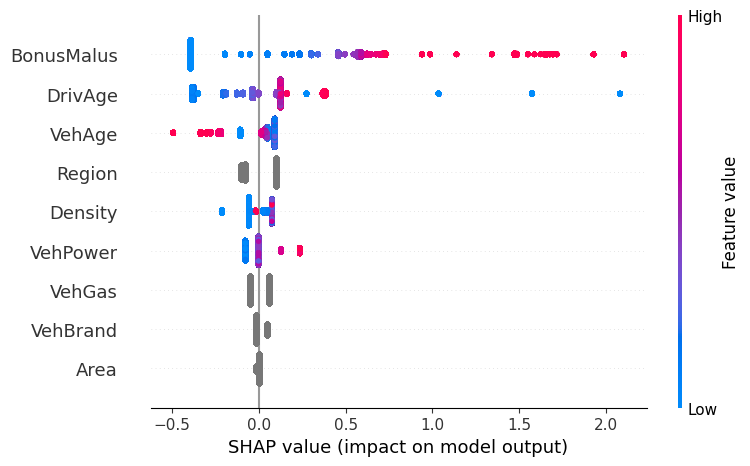

In [50]:
explainer = shap.TreeExplainer(cb_regressor)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)

In [51]:
train_y2 = train_y/cb_regressor.predict(train_X)
test_y2 = test_y/cb_regressor.predict(test_X)

In [52]:
cb_regressor2 = CatBoostRegressor(
    loss_function="Tweedie:variance_power=1.5",
    depth=2
)
cb_regressor2.fit(
    train_X,
    train_y2,
    sample_weight=train_weights,
    cat_features=["Area", "VehBrand", "VehGas", "Region"],
    eval_set=(test_X, test_y2)
)

0:	learn: 3.9497633	test: 3.9070737	best: 3.9070737 (0)	total: 55.5ms	remaining: 55.5s
1:	learn: 3.9495074	test: 3.9069533	best: 3.9069533 (1)	total: 92.4ms	remaining: 46.1s
2:	learn: 3.9494246	test: 3.9068157	best: 3.9068157 (2)	total: 130ms	remaining: 43.1s
3:	learn: 3.9492664	test: 3.9068219	best: 3.9068157 (2)	total: 155ms	remaining: 38.6s
4:	learn: 3.9488636	test: 3.9067511	best: 3.9067511 (4)	total: 191ms	remaining: 38.1s
5:	learn: 3.9487907	test: 3.9066268	best: 3.9066268 (5)	total: 220ms	remaining: 36.4s
6:	learn: 3.9487220	test: 3.9065081	best: 3.9065081 (6)	total: 245ms	remaining: 34.7s
7:	learn: 3.9484701	test: 3.9060715	best: 3.9060715 (7)	total: 281ms	remaining: 34.9s
8:	learn: 3.9482819	test: 3.9060284	best: 3.9060284 (8)	total: 318ms	remaining: 35s
9:	learn: 3.9482183	test: 3.9059171	best: 3.9059171 (9)	total: 347ms	remaining: 34.4s
10:	learn: 3.9481598	test: 3.9058693	best: 3.9058693 (10)	total: 381ms	remaining: 34.3s
11:	learn: 3.9479934	test: 3.9057872	best: 3.9057872

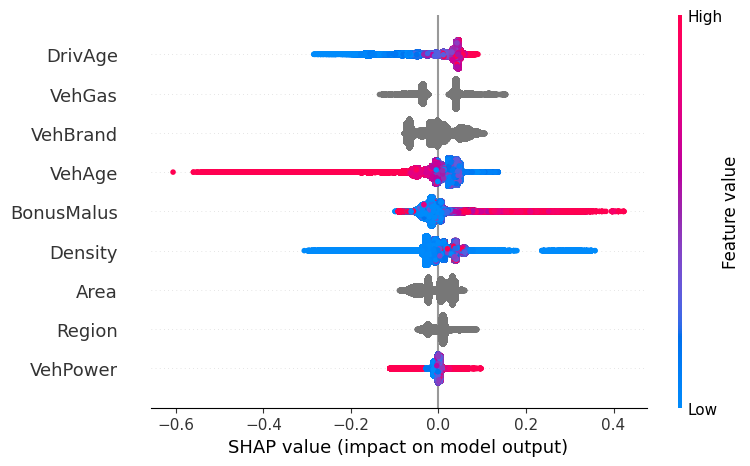

In [54]:
explainer2 = shap.TreeExplainer(cb_regressor2)
shap_values = explainer2(X)
shap.plots.beeswarm(shap_values)

In [57]:
predictions = cb_regressor.predict(test_X) * cb_regressor2.predict(test_X)

In [58]:
cb_regressor3 = CatBoostRegressor(
    loss_function="Tweedie:variance_power=1.5",
    depth=2
)
cb_regressor3.fit(
    train_X,
    train_y,
    sample_weight=train_weights,
    cat_features=["Area", "VehBrand", "VehGas", "Region"],
    eval_set=(test_X, test_y)
)

0:	learn: 190.5491759	test: 172.0365594	best: 172.0365594 (0)	total: 40.4ms	remaining: 40.4s
1:	learn: 185.1583320	test: 167.1864259	best: 167.1864259 (1)	total: 75ms	remaining: 37.4s
2:	learn: 179.9335963	test: 162.4878413	best: 162.4878413 (2)	total: 110ms	remaining: 36.7s
3:	learn: 174.8706412	test: 157.9336905	best: 157.9336905 (3)	total: 136ms	remaining: 33.9s
4:	learn: 169.9646943	test: 153.5205696	best: 153.5205696 (4)	total: 162ms	remaining: 32.2s
5:	learn: 165.2110032	test: 149.2474436	best: 149.2474436 (5)	total: 195ms	remaining: 32.3s
6:	learn: 160.6057918	test: 145.1066301	best: 145.1066301 (6)	total: 223ms	remaining: 31.7s
7:	learn: 156.1446369	test: 141.0951271	best: 141.0951271 (7)	total: 254ms	remaining: 31.4s
8:	learn: 151.8234572	test: 137.2100703	best: 137.2100703 (8)	total: 280ms	remaining: 30.8s
9:	learn: 147.6381347	test: 133.4515863	best: 133.4515863 (9)	total: 312ms	remaining: 30.9s
10:	learn: 143.5850071	test: 129.8125386	best: 129.8125386 (10)	total: 343ms	rem

In [66]:
shap_values

.values =
array([[ 0.00692236, -0.00070985,  0.00146622, ..., -0.03746478,
         0.01346952,  0.01000097],
       [ 0.00692236, -0.00070985,  0.00146622, ..., -0.03746478,
         0.01346952,  0.01000097],
       [-0.05433331,  0.0045785 ,  0.02590487, ...,  0.03975764,
        -0.00705026,  0.00452738],
       ...,
       [ 0.00683103,  0.00351228,  0.02574906, ...,  0.03908842,
         0.02117292,  0.0098962 ],
       [-0.05490131, -0.00975784, -0.00236743, ..., -0.03818183,
        -0.02751673,  0.00458028],
       [-0.04909316, -0.00170113,  0.03485783, ...,  0.04281377,
        -0.01234915,  0.00635413]])

.base_values =
array([-0.05043205, -0.05043205, -0.05043205, ..., -0.05043205,
       -0.05043205, -0.05043205])

.data =
array([['D', 5, 0, ..., 'Regular', 1217, 'R82'],
       ['D', 5, 0, ..., 'Regular', 1217, 'R82'],
       ['B', 6, 2, ..., 'Diesel', 54, 'R22'],
       ...,
       ['D', 6, 2, ..., 'Diesel', 1323, 'R82'],
       ['B', 4, 0, ..., 'Regular', 95, 'R26'],
   

In [63]:
predictions

array([105.39767191, 150.67595257, 181.8487947 , ..., 123.27842242,
        76.41842758, 134.07072133])

In [65]:
prediction3

array([ 97.35605787, 165.77136632, 184.56648617, ..., 136.75787866,
        76.0646652 , 128.81076835])